## Imports

In [1]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping, LRScheduler

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt

import numpy as np

import os

from src.models.TurbulenceNetwork import TurbulenceNetwork
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device: ", device)

%load_ext autoreload
%autoreload 2


Device:  cuda:0


## Misc Utilities

In [2]:
class MAPELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MAPELoss, self).__init__()
        self.eta = 1e-9

    def forward(self, y_pred, y_true):
        l = torch.abs((y_true - y_pred)) / (torch.abs(y_true) + self.eta)

        return torch.mean(l)

class RMSELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(RMSELoss, self).__init__()
        self.eta = 1e-8

    def forward(self, y_pred, y_true):
        l = torch.sqrt(torch.mean(torch.pow((y_true - y_pred), 2)))

        return l


## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:88: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


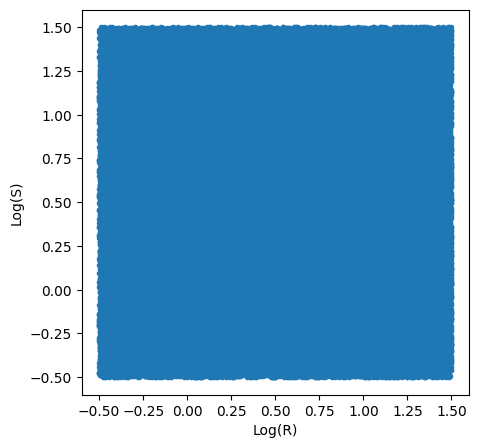

In [3]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 1.5)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 40_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)


In [4]:
x_scaler = StandardScaler().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train)
y_train = torch.tensor(y_scaled_train)


x_test = torch.tensor(x_scaler.transform(etas_test))
y_test = torch.tensor(y_scaler.transform(gs_test))

## Network Training

In [5]:
# Defining model parameters
checkpoint_dir = './Model_Checkpoints/ensemble/'


net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 3,
        "h_dim": 20,
        "dropout": 0.00,
}

train_params = {
        "criterion": nn.MSELoss,
        "optimizer": torch.optim.Adam,
        "optimizer__weight_decay": 0.00001,
        "lr": 0.001,
        "batch_size": 64,
        "max_epochs": 100,
        "device": device,
        "iterator_train__shuffle": True,
        "iterator_train__num_workers": 4,
        "iterator_train__pin_memory": True,
        "iterator_valid__shuffle": False,
        "iterator_valid__num_workers": 4,
        "iterator_valid__pin_memory": True,
        "verbose": 1,
}

num_members = 10

In [6]:
test_criteria = RMSELoss()


for i in range(num_members):
        callbacks = [EarlyStopping(patience=15, threshold=0.0001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
                Checkpoint(monitor='valid_loss_best', f_params=f'TurbulenceNetwork_Ens_{i}.pt', dirname=checkpoint_dir),
                LRScheduler(policy=ReduceLROnPlateau, monitor='valid_loss', factor=0.5, patience=5, threshold=0.0001, threshold_mode='abs', mode='min', verbose=True)
        ]
        train_params['callbacks'] = callbacks

        net = create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
        net = net.fit(x_train, y_train)

        net.load_params(f_params=checkpoint_dir+f'TurbulenceNetwork_Ens_{i}.pt')
        test_pred = net.predict(x_test)
        print(f"\t\tTest loss: {test_criteria(test_pred, y_test)}")


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


/home/codygrogan/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.6230        0.4450     +  1.4807
      2        0.3945        0.3282     +  1.3121
      3        0.3148        0.2690     +  1.3648
      4        0.2642        0.2289     +  1.3392
      5        0.2306        0.1967     +  1.3085
      6        0.1989        0.1817     +  1.3142
      7        0.1749        0.1792     +  1.3030
      8        0.1562        0.1313     +  1.3102
      9        0.1369        0.1171     +  1.2810
     10        0.1229        0.1176        1.2435
     11        0.1122        0.0939     +  1.3352
     12        0.1008        0.0820     +  1.3148
     13        0.0942        0.0908        1.3296
     14        0.0885        0.0727     +  1.3903
     15        0.0792        0.0672     +  1.3389
     16        0.0735        0.0628     +  1.3730
     17        0.0700        0.0538     +  1.3754
     18        0.0658        0.0533     +  1.3608


## Creating Ensemble

In [7]:
ensemble = []

for i in range(num_members):
    net = reinitialize_model(f'TurbulenceNetwork_Ens_{i}.pt', checkpoint_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    ensemble.append(net)


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


## Generating Statistics Data

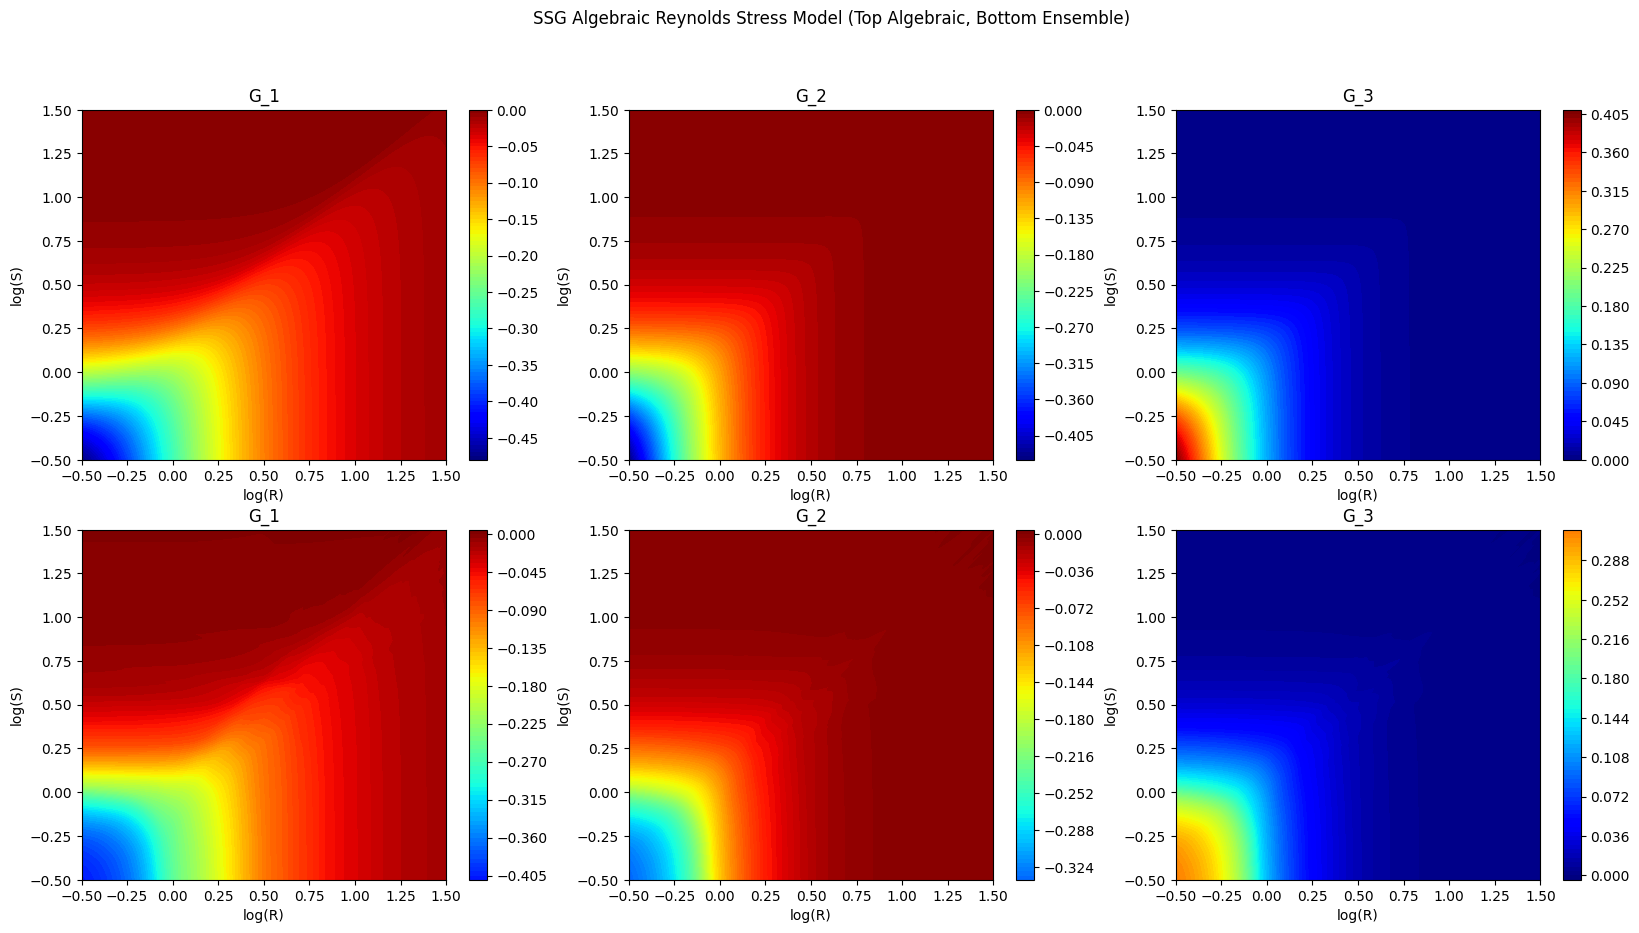

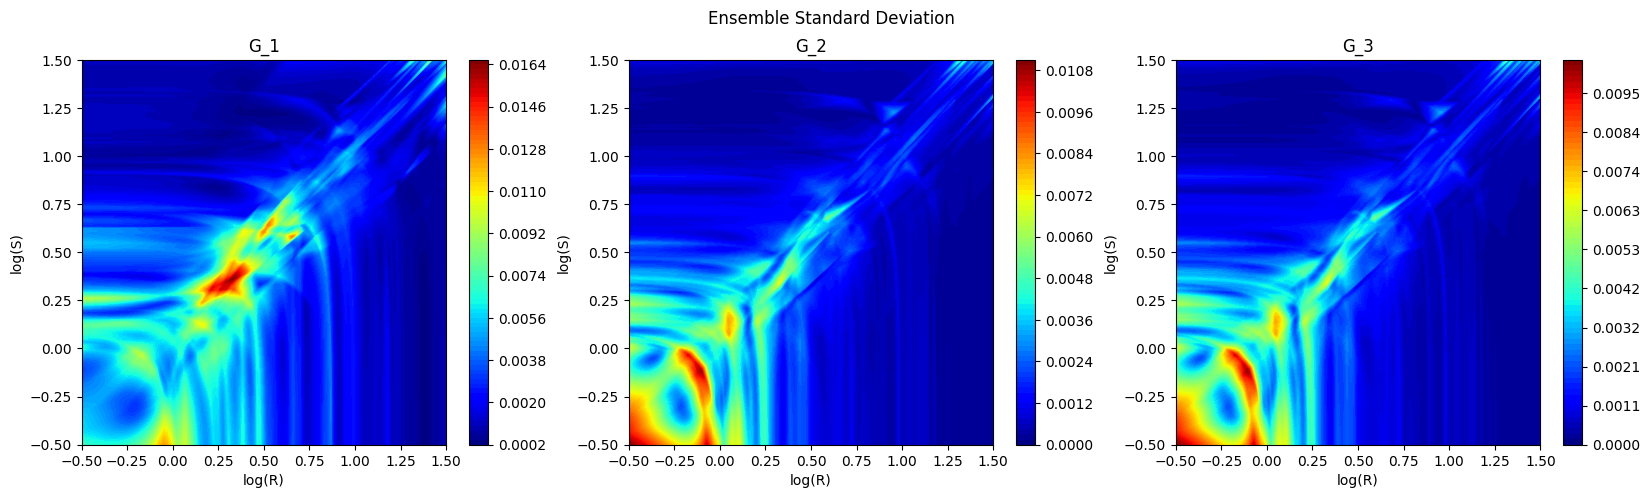

In [8]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

etas = x_scaler.transform(etas)

preds = np.zeros((num_members, len(etas), 3))

for i in range(num_members):
    pred = ensemble[i].predict(etas)
    preds[i] = y_scaler.inverse_transform(pred)


pred = preds.mean(axis=0).T.reshape(3, dim, dim)

std = preds.std(axis=0).T.reshape(3, dim, dim)

plot_heat_map_compare(x_grid, y_grid, target, pred, 'Algebraic', 'Ensemble')

plot_heat_map_3D(x_grid, y_grid, std, "Ensemble Standard Deviation")